In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Google Colab
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Jupyter Notebook/VS Code
# %pip install wget
# import wget
# wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-05-30 11:46:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-30 11:46:20 (75.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Mount data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/dataset_reduced.zip > /dev/null

Mounted at /content/gdrive


In [4]:
# Walk through each directory
dataset = "/content/asl_alphabet_train"
# dataset = "./Car Accident/"
walk_through_dir(dataset)

There are 29 directories and 0 images in '/content/asl_alphabet_train'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/Y'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/H'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/W'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/V'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/del'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/K'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/X'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/E'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/D'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/G'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/M'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/B'.
There are 0 directories an

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.JPEG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

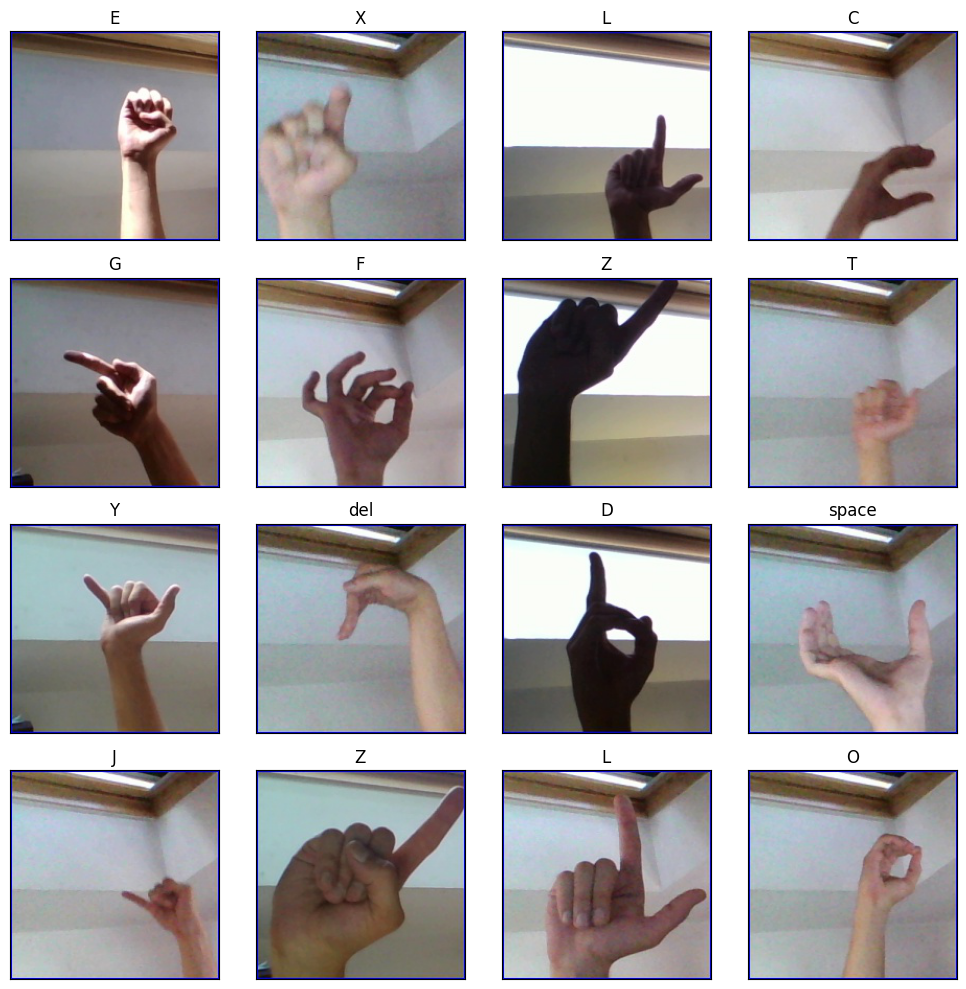

In [8]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=1)

In [10]:
!pip install tensorflow tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.1 MB/s eta 0:00:00


In [11]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
from tensorflow.keras.applications.efficientnet import preprocess_input
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [13]:
BATCH_SIZE = 100
IMAGE_SIZE = (224, 224)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8120 validated image filenames belonging to 29 classes.
Found 2030 validated image filenames belonging to 29 classes.
Found 4350 validated image filenames belonging to 29 classes.


In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(250,250),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

# **EfficientNetB0**


In [16]:
pretrained_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = False
pretrained_model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescal

In [17]:
model = Sequential()
model.add(pretrained_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation='softmax'))  # Replace num_classes with the number of your classes

# Ensure the input shape matches the output shape of the preceding layer
model.build((None, 7, 7, 1280))  # Adjust the input shape to match the output shape of the EfficientNetB0 model

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 29)                3741      
                                                                 
Total params: 4,217,280
Trainable params: 167,709
Non-trainable params: 4,049,571
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 29)                3741      
                                                                 
Total params: 4,217,280
Trainable params: 167,709
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50
)

Epoch 1/50
82/82 [==============================] - 53s 430ms/step - loss: 1.4488 - accuracy: 0.6846 - val_loss: 0.4836 - val_accuracy: 0.9207
Epoch 2/50
82/82 [==============================] - 29s 349ms/step - loss: 0.3453 - accuracy: 0.9426 - val_loss: 0.2303 - val_accuracy: 0.9591
Epoch 3/50
82/82 [==============================] - 29s 349ms/step - loss: 0.1866 - accuracy: 0.9683 - val_loss: 0.1484 - val_accuracy: 0.9739
Epoch 4/50
82/82 [==============================] - 34s 414ms/step - loss: 0.1260 - accuracy: 0.9803 - val_loss: 0.0965 - val_accuracy: 0.9887
Epoch 5/50
82/82 [==============================] - 29s 347ms/step - loss: 0.0977 - accuracy: 0.9856 - val_loss: 0.0757 - val_accuracy: 0.9897
Epoch 6/50
82/82 [==============================] - 29s 346ms/step - loss: 0.0691 - accuracy: 0.9910 - val_loss: 0.0597 - val_accuracy: 0.9931
Epoch 7/50
82/82 [==============================] - 28s 345ms/step - loss: 0.0595 - accuracy: 0.9913 - val_loss: 0.0529 - val_accuracy: 0.9921

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01165
Test Accuracy: 99.54%


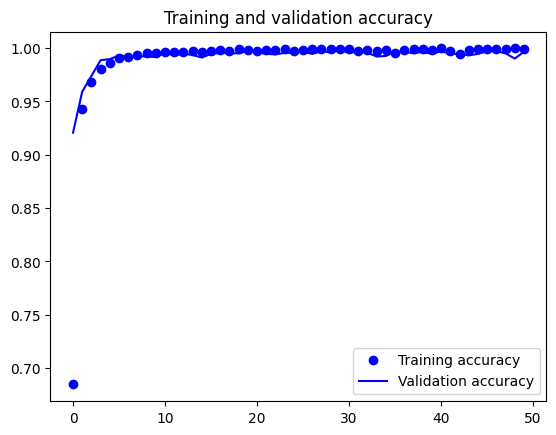

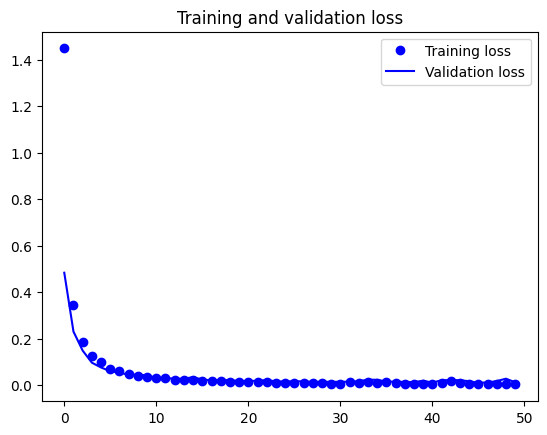

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

44/44 [==============================] - 15s 309ms/step
The first 5 predictions: ['Z', 'P', 'Q', 'T', 'nothing']


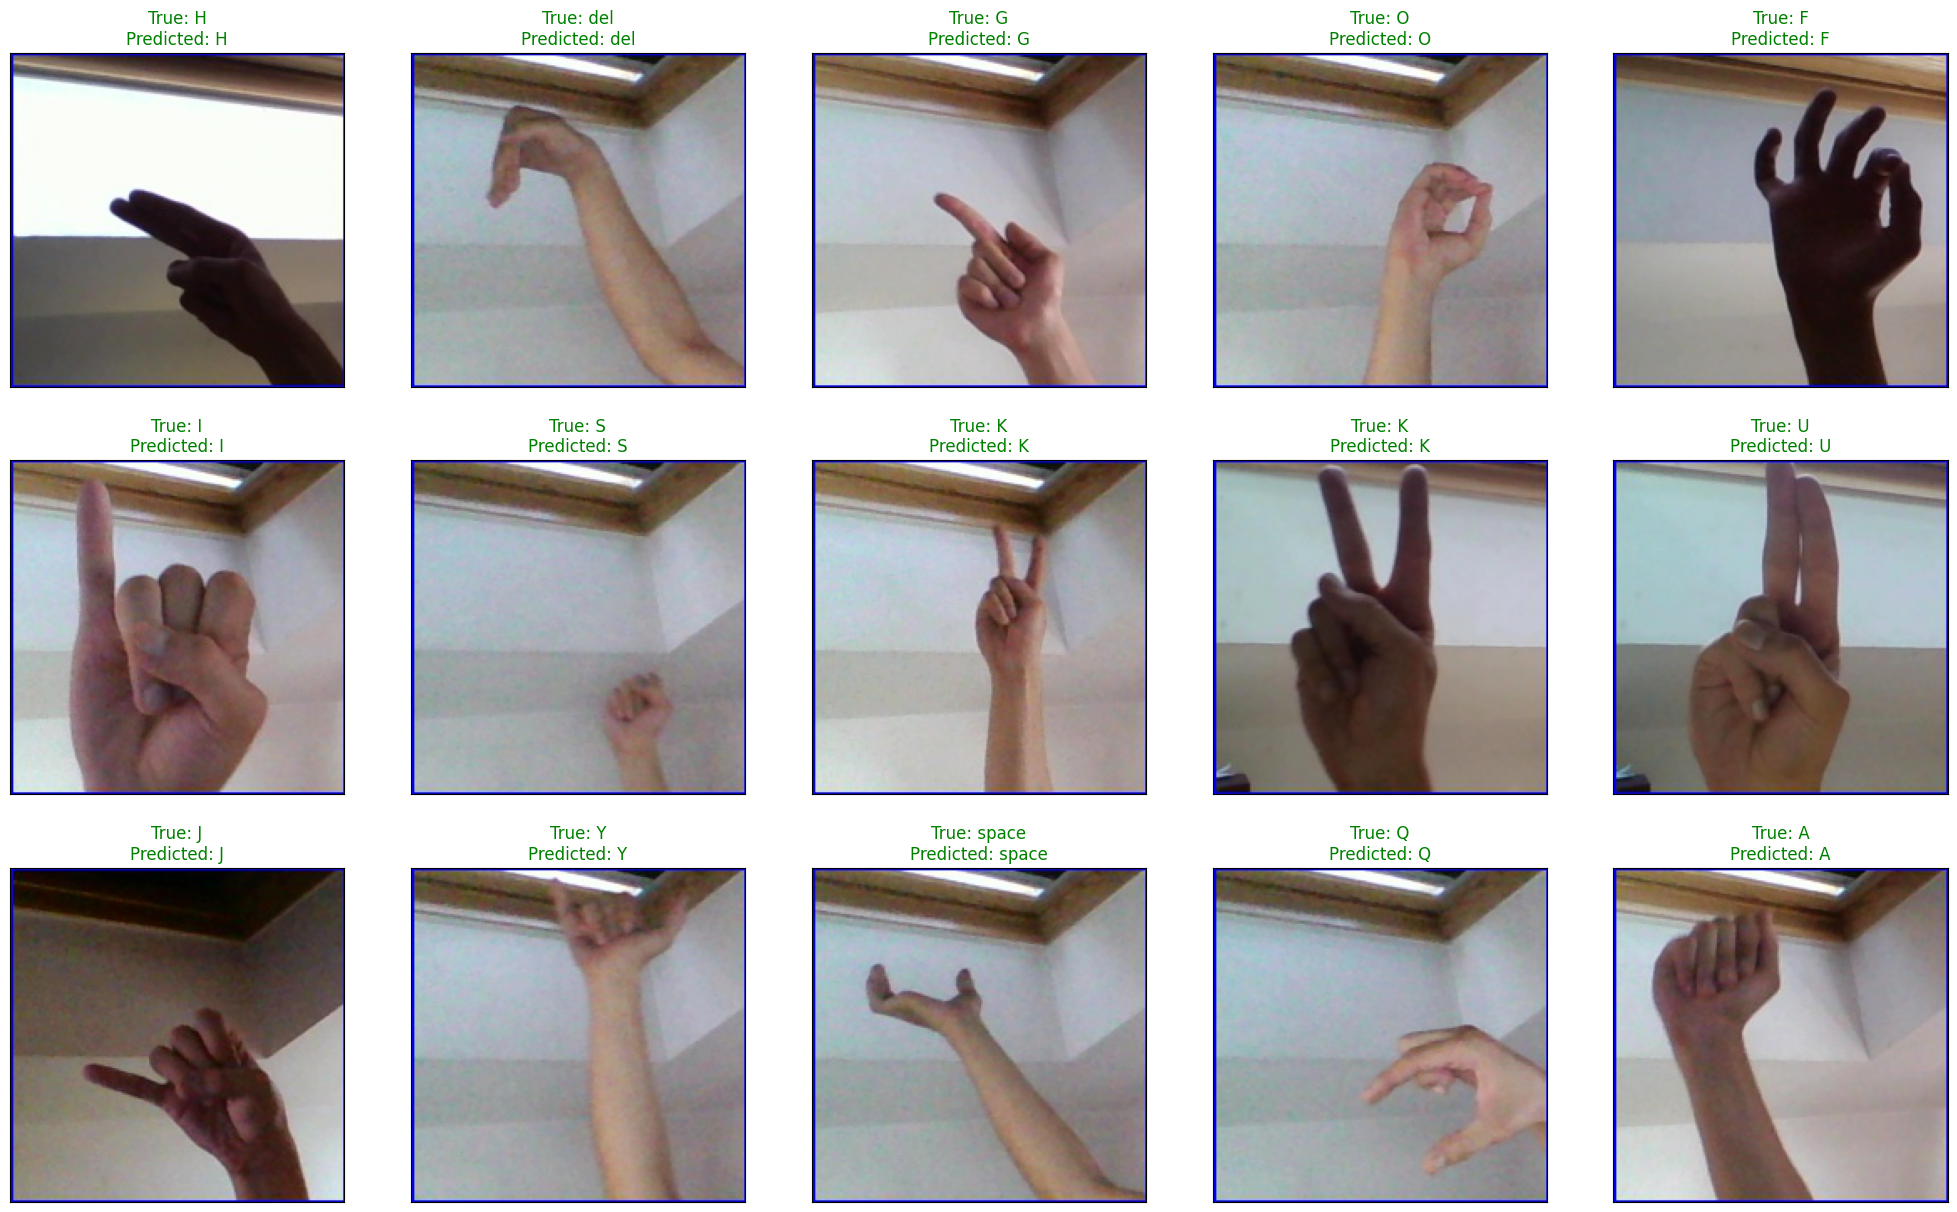

<Figure size 640x480 with 0 Axes>

In [23]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [24]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.99      1.00      1.00       143
           B       0.99      1.00      1.00       147
           C       1.00      1.00      1.00       151
           D       1.00      1.00      1.00       160
           E       1.00      0.98      0.99       143
           F       0.99      1.00      1.00       153
           G       0.99      1.00      1.00       159
           H       1.00      0.99      1.00       162
           I       0.99      1.00      1.00       140
           J       1.00      0.99      0.99       158
           K       1.00      0.99      0.99       153
           L       1.00      1.00      1.00       142
           M       0.97      1.00      0.99       141
           N       1.00      0.98      0.99       162
           O       1.00      1.00      1.00       147
           P       0.99      1.00      1.00       144
           Q       1.00      1.00      1.00       155
           R       1.00    

In [25]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
A,0.993056,1.000000,0.996516,143.000000
B,0.993243,1.000000,0.996610,147.000000
C,1.000000,1.000000,1.000000,151.000000
D,1.000000,1.000000,1.000000,160.000000
E,1.000000,0.979021,0.989399,143.000000
F,0.993506,1.000000,0.996743,153.000000
G,0.993750,1.000000,0.996865,159.000000
H,1.000000,0.993827,0.996904,162.000000
I,0.992908,1.000000,0.996441,140.000000
J,1.000000,0.987342,0.993631,158.000000
